In [1]:
import numpy as np
import scipy as sc
import cupy as cp
import matplotlib.pyplot as plt
import quantecon as qe
from scipy.optimize import minimize_scalar

In [2]:
print(cp.cuda.runtime.getDeviceCount())

1


In [3]:
print(cp.cuda.Device(0))

<CUDA Device 0>


In [14]:
# P = [n_a, beta, theta, n_z, rho, sigma, mu, gamma]
P = [101, 0.96, 2, 19, 0.95, 0.2, 0, 1]

In [12]:
def expanding_grid(params):

    zero_grid = np.linspace(0,1,params[0]).reshape(-1,1)

    asset_grid = np.zeros(shape=(params[0],1))

    a_low = 0

    a_high = 100

    for i in range(P[0]):
        asset_grid[i] = (a_low) + (a_high - a_low) * (zero_grid[i] ** P[2])

    return asset_grid

In [6]:
def u(c, params):
    if params[-1] == 1:
        return np.log(c)
    else:
        return ((c**(1-params[-1]))/(1-params[-1]))

In [7]:
def Markov_chain(params):

    n_z, rho, sigma, mu =  params[3], params[4], params[5], params[6]
    
  # mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    
    z_grid, T = mc.state_values, mc.P

    return z_grid, T

In [8]:
def optimiser(a, params, A, Z, phi, w, Interp_Ev):
    return - (u( w * np.exp(np.squeeze(Z[j])) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

In [9]:
def B(V, G, params, r, w, T, A, Z, phi):

  # z_grid, T = Markov_chain(P)

  # asset_grid = expanding_grid(P)

  # V_init = cp.zeros(shape=(n_a, n_z))
  # V = cp.zeros(P[0], P[3])
  # G = cp.zeros(P[0], P[3])
                      
  #  if b>0:

  #      phi = cp.min([b, (w * cp.min(z_grid))/r])

  #  else:

  #      phi = b

    for j in range(params[3]):

        Expected_value = V * T[j,:]

        Interp_Ev = sc.interpolate.interp1d(np.squeeze(A), np.squeeze(Expected_value[:,j]), kind='cubic', fill_value='extrapolate')

        for i in range(params[0]):

                objective = lambda a: - (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))
                # print(objective(0))
              # def optimiser(a, params, A, Z, phi, w, Interp_Ev):
              #    return - (u( w * np.exp(np.squeeze(Z[j])) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                lb = 0

                ub = (w * np.exp(Z[j])) + ((1+r) * A[i])

                result = minimize_scalar(objective, bounds=(lb, ub), method = 'bounded')
               # result = minimize_scalar(optimiser, args = (params, A, Z, phi, w, Interp_Ev), bounds=(lb, ub), method = 'bounded')

                argmax = result.x

                value = -result.fun

                min = np.float64(objective(0))

                # print(type(min))

                if value < min:

                    G[i,j] = lb

                    V[i,j] = min
            
                else:

                    G[i,j] = argmax

                    V[i,j] = value                    

    return V, G    

In [10]:
def iterate(params, r, w, b, toler, max_iter):

    iter = 0
    
    error = toler + 1
    
    z_grid, T = Markov_chain(params)

    #z_grid = np.asarray(z_grid)

    #T = np.asarray(T)
    
    asset_grid = expanding_grid(params)
    #print(asset_grid.shape)

    # V0 = cp.zeros(shape=(n_a, n_z))
    V = np.zeros(shape=(params[0], params[3]))
    G = np.zeros(shape=(params[0], params[3]))
                      
    if b > 0 :

         phi = np.min([b, (w * np.min(z_grid))/r])

    else:

         phi = b

    while iter <= max_iter:

         V1, G1 = B(V, G, params, r, w, T, asset_grid, z_grid, phi)
        
         error = np.max(np.abs(V1-V))

         iter +=1

         V = np.copy(V1)

         G = np.copy(G1)

         if iter % 10 == 0:
             print(f"Iteration {iter}, Error: {error}")

         iter +=1
        
         if error < toler:
             print(f"Converged in {iter + 1} iterations")
             break

         if iter == max_iter:
             print(f"failed to converge in {iter} iterations")
             break

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, V[:, j], label=f'TFP Shock {j+1}')

    ax.set_title('Value Function')
    ax.set_xlabel('Asset Holdings')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    # Plot the policy function
    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, G[:, j], label=f'TFP Shock {j+1}')

    ax.set_title('Policy Function')
    ax.set_xlabel('Current Asset Holdings')
    ax.set_ylabel('Optimal Next Period Asset Holdings')
    ax.legend()
    plt.show()

    return V, G

C:\Users\bayle\AppData\Local\Temp\ipykernel_27368\598050104.py:6: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
C:\Users\bayle\AppData\Local\Temp\ipykernel_27368\267496873.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min = np.float64(objective(0))
C:\Users\bayle\AppData\Local\Temp\ipykernel_27368\267496873.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G[i,j] = argmax
C:\Users\bayle\AppData\Loc

Converged in 3 iterations


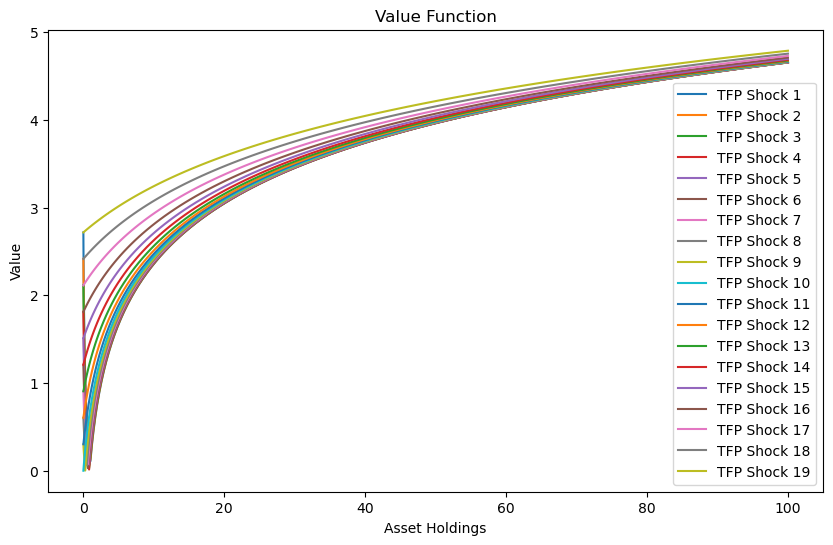

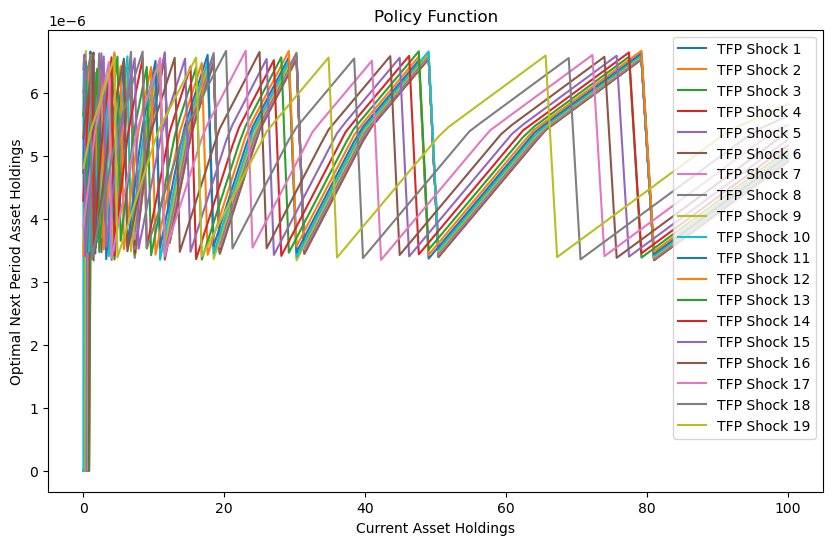

In [15]:
V_out, G_out = iterate(P, r=0.05, w=1.0, b=0.0, toler=1e-6, max_iter=100000)

In [17]:
def findfirst(predicate, array):
    for i, x in enumerate(array):
        if predicate(x):
            return i
        else:
            return print("None")

In [44]:
def Invariant_Distirbution(params, policy, transition_matrix, grid):
   # M(i, j, k, l) -> current state: (i,j), next state: (k,l)
    M = np.zeros(shape=(params[0], params[3], params[0], params[3]))
   # for i in range(n_a):
    for i in range(params[0]):
       # for j in range(n_z):
        for j in range(params[3]):
           # if G1[i,j]<=np.squeeze(grid[1]):
            if policy[i,j]<=np.min(grid):
               # if you stay at the borrowing constraint across periods, your transition is only affected by evolution of AR1 process. 
                M[i,j,1,:] = transition[j,:]

            elif policy[i,j]>=np.max(grid):
               # if you stay at the max asset holdings across periods, your transition is only affected by evolution of AR1 process.
                M[i,j,params[0],:] = transition[j,:]

            else:
              # Some explanation is required for this step.
              # The "findfirst" function is defined above. There, we ask Python to look at the row vector, and return 
              # the index of the first element where the predicate is true.
                index = findfirst(lambda x: x > policy[i,j], grid)
              # Individuals have chosen policy[i,j] from a continuous choice set.
              # However, policy[i,j] may not necessarily lie on our asset grid. We need to move them to a grid point.
              # We linearly intepolate a probability based on the position of policy[i,j] with regard to the grid points closest.
              # Individuals are more likely to transition to whichever grid point is closer.
                prob = (grid[index] - policy[i,j])/(grid[index] - grid[index-1])
                
                M[i,j,index-1,:] = transition[j,:]*prob
                
                M[i,j,index,:] = transition[j,:]*(1-prob)

    O = np.zeros(shape=(params[0] * params[3], params[0] * params[3]))
                 
    l=0
    
    for i in range(params[0]):
        
        for j in range(params[3]):
            
            O[:,j+l*params[3]]  = M[:,:,i,j].T.flatten()

        l=l+1

    for i in range(params[0]*params[3]):

        O[i, :] = (O[i, :]) / (np.sum(O[i, :]))

    number_of_states = params[0]*params[3]

    X = [

    

    
            

                
    

In [43]:
# Check that flatten is doing the correct thing!
trial = np.zeros(shape=(101,19,101,19))
for i in range(101):
    for j in range(19):
        flattened = trial[:,:,i,j].T.flatten()
        if i == 0 and j == 0:
            print(flattened.shape)

(1919,)
